<a href="https://colab.research.google.com/github/ElshadaiK/COMPAS-Recidivism-Bias-Analysis/blob/main/Compas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Cleaning

## Dataset Description

In [33]:
# Importing the necessary library
import pandas as pd

# Loading the dataset
df = pd.read_csv('../data/cox-violent-parsed.csv')

# Displaying basic information about the dataset
print("Dataset Information:")
print(df.info())

# Displaying the first few rows of the dataset for a preview
print("\nFirst 5 Rows of the Dataset:")
print(df.head())

# Checking for missing values in each column
print("\nMissing Values in Each Column:")
print(df.isnull().sum())


Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18316 entries, 0 to 18315
Data columns (total 52 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       11001 non-null  float64
 1   name                     18316 non-null  object 
 2   first                    18316 non-null  object 
 3   last                     18316 non-null  object 
 4   compas_screening_date    18316 non-null  object 
 5   sex                      18316 non-null  object 
 6   dob                      18316 non-null  object 
 7   age                      18316 non-null  int64  
 8   age_cat                  18316 non-null  object 
 9   race                     18316 non-null  object 
 10  juv_fel_count            18316 non-null  int64  
 11  decile_score             18316 non-null  int64  
 12  juv_misd_count           18316 non-null  int64  
 13  juv_other_count          18316 non-null  int64  
 14  p

**Note**: This section loads the COMPAS dataset and provides basic information. The dataset contains details about individuals involved in the criminal justice system, along with various attributes like age, race, charge descriptions, and COMPAS scores (used for assessing recidivism risk). The initial exploration includes checking for missing values, which is crucial for understanding the dataset's quality.

## Data Cleaning and Preprocessing

### Dropping Columns with High Missing Values

In [34]:
# Dropping columns with a high number of missing values
# These columns are removed because they have too many missing entries,
# which makes them unreliable for analysis.
df.drop(['violent_recid', 'vr_case_number', 'vr_charge_desc', 'c_case_number'], axis=1, inplace=True)


**Explanation**: In this cell, columns with a significant number of missing values are being dropped from the dataset. Columns like 'violent_recid', 'vr_case_number', 'vr_charge_desc', and 'c_case_number' are removed because their high level of missing data could skew the analysis and lead to unreliable conclusions.

### Converting Date Columns

In [35]:
# Converting date columns to datetime format and extracting year and month
# This conversion is necessary to use these dates in a meaningful way in the analysis.
df['c_arrest_date'] = pd.to_datetime(df['c_arrest_date'], format='%d/%m/%Y', errors='coerce')
df['c_arrest_year'] = df['c_arrest_date'].dt.year
df['c_arrest_month'] = df['c_arrest_date'].dt.month

# Similar conversions for other date columns
df['r_offense_date'] = pd.to_datetime(df['r_offense_date'], format='%d/%m/%Y', errors='coerce')
df['r_offense_year'] = df['r_offense_date'].dt.year
df['r_offense_month'] = df['r_offense_date'].dt.month


**Explanation**: This cell converts various date columns from string format to Python datetime objects. This conversion allows for easier manipulation and extraction of specific components like the year and month, which are often more useful for analysis than the full date.

### Calculating Jail Duration

In [36]:
# Converting jail in and out dates to datetime and calculating the duration of jail time
# The duration in jail could be a significant factor in the analysis.
df['r_jail_in'] = pd.to_datetime(df['r_jail_in'], format='%d/%m/%Y', errors='coerce')
df['r_jail_out'] = pd.to_datetime(df['r_jail_out'], format='%d/%m/%Y', errors='coerce')
df['c_jail_in'] = pd.to_datetime(df['c_jail_in'], format='%d/%m/%Y', errors='coerce')
df['c_jail_out'] = pd.to_datetime(df['c_jail_out'], format='%d/%m/%Y', errors='coerce')

df['r_jail_duration'] = (df['r_jail_out'] - df['r_jail_in']).dt.days
df['c_jail_duration'] = (df['c_jail_out'] - df['c_jail_in']).dt.days


**Explanation**: In this cell, the 'in' and 'out' jail dates are converted to datetime format, and the duration of each jail stay is calculated. This information is valuable as it quantifies the time spent in jail, which might be a relevant factor in the analysis, especially for assessing recidivism risk or other behavioral patterns.

### Dropping Original Date Columns and Personal Identifying Information

In [37]:
# Dropping the original date columns and personal identifying information
# Personal information is removed for privacy, and original date columns are dropped
# as they are no longer needed after extracting the year, month, and duration.
df.drop(['c_arrest_date', 'r_offense_date', 'r_jail_in', 'r_jail_out', 'c_jail_in', 'c_jail_out',
         'id', 'name', 'first', 'last'], axis=1, inplace=True)

**Explanation**: This cell removes personal identifying information (like names and IDs) to ensure privacy and confidentiality. Additionally, original date columns are dropped since the necessary information (year, month, duration) has already been extracted.

### One-Hot Encoding of Categorical Variables

In [38]:
# Check unique values in the 'race' column before one-hot encoding
print("Unique race categories before one-hot encoding:", df['race'].unique())


Unique race categories before one-hot encoding: ['Other' 'Caucasian' 'African-American' 'Hispanic' 'Asian'
 'Native American']


In [39]:
# Check unique values in the 'sex' column before one-hot encoding
print("Unique sex categories before one-hot encoding:", df['sex'].unique())


Unique sex categories before one-hot encoding: ['Male' 'Female']


In [40]:
# Replace spaces with underscores in the 'race' column
df['race'] = df['race'].str.replace(' ', '_')


In [41]:
# Manually create a column for 'African-American'
df['race_African_American'] = df['race'].apply(lambda x: 1 if x == 'African-American' else 0)


In [42]:
# Converting categorical variables (like race, sex) into numerical format using one-hot encoding
# One-hot encoding creates new columns indicating the presence of each possible value in the original data.
df = pd.get_dummies(df, columns=['race', 'sex', 'age_cat', 'c_charge_degree'], drop_first=True)

**Explanation**: Categorical variables are transformed into a numerical format using one-hot encoding. This process is crucial for machine learning models, as they require numerical input. One-hot encoding creates a separate column for each category within a variable, marked with 1 if the category is present and 0 otherwise.

### Further Data Cleaning

In [43]:
# Dropping duplicate or redundant columns and calculating age at COMPAS screening
# Redundant columns are removed, and age at screening is calculated for further analysis.
df.drop(['decile_score.1', 'priors_count.1'], axis=1, inplace=True)

df['compas_screening_date'] = pd.to_datetime(df['compas_screening_date'], format='%d/%m/%Y', errors='coerce')
df['dob'] = pd.to_datetime(df['dob'], format='%d/%m/%Y', errors='coerce')
df['age_at_screening'] = df['compas_screening_date'].dt.year - df['dob'].dt.year
df.drop(['dob', 'compas_screening_date'], axis=1, inplace=True)

# Handling missing values in various columns
df['days_b_screening_arrest'].fillna(df['days_b_screening_arrest'].median(), inplace=True)
df['c_charge_desc'].fillna('Unknown', inplace=True)

# Creating a new field for total prior offenses
df['total_prior_offenses'] = df['juv_fel_count'] + df['juv_misd_count'] + df['juv_other_count']

# Further handling of missing values
columns_to_drop = ['c_offense_date', 'r_case_number', 'r_charge_degree', 'r_days_from_arrest', 'r_charge_desc',
                   'vr_charge_degree', 'vr_offense_date', 'c_arrest_year', 'c_arrest_month',
                   'r_offense_year', 'r_offense_month', 'r_jail_duration', 'c_jail_duration']
df.drop(columns_to_drop, axis=1, inplace=True)
df['c_days_from_compas'].fillna(df['c_days_from_compas'].median(), inplace=True)
df['in_custody'].fillna('Unknown', inplace=True)
df['out_custody'].fillna('Unknown', inplace=True)
df['score_text'].fillna(df['score_text'].mode()[0], inplace=True)
df['v_score_text'].fillna(df['v_score_text'].mode()[0], inplace=True)

# Final check for missing values
print("Final result after handling missing values:")
print(df.isnull().sum())


Final result after handling missing values:
age                        0
juv_fel_count              0
decile_score               0
juv_misd_count             0
juv_other_count            0
priors_count               0
days_b_screening_arrest    0
c_days_from_compas         0
c_charge_desc              0
is_recid                   0
is_violent_recid           0
type_of_assessment         0
score_text                 0
screening_date             0
v_type_of_assessment       0
v_decile_score             0
v_score_text               0
v_screening_date           0
in_custody                 0
out_custody                0
start                      0
end                        0
event                      0
race_African_American      0
race_Asian                 0
race_Caucasian             0
race_Hispanic              0
race_Native_American       0
race_Other                 0
sex_Male                   0
age_cat_Greater than 45    0
age_cat_Less than 25       0
c_charge_degree_(CT)       0

/var/folders/z8/_vvjvjp17jx590_gh4qpr1z40000gn/T/ipykernel_84101/913148118.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['days_b_screening_arrest'].fillna(df['days_b_screening_arrest'].median(), inplace=True)
/var/folders/z8/_vvjvjp17jx590_gh4qpr1z40000gn/T/ipykernel_84101/913148118.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate 

**Explanation**: This cell includes the final stages of data cleaning. It involves dropping unnecessary or redundant columns, filling in missing values, and creating new variables that might be relevant to the analysis. The goal is to ensure that the dataset is complete, accurate, and ready for machine learning modeling.

# Building the Decision Tree Model

### Preparing Data for the Model

In [44]:
from sklearn.model_selection import train_test_split

# Preparing data for the model
# We are dropping columns that are not needed for prediction
# and defining 'is_recid' as our target variable.
X = df.drop(['is_recid', 'c_charge_desc', 'type_of_assessment', 'score_text',
             'screening_date', 'v_type_of_assessment', 'v_score_text',
             'v_screening_date', 'in_custody', 'out_custody'], axis=1)
y = df['is_recid']


Explanation: This cell prepares the dataset for the decision tree model. Features (`X`) and the target variable (`y`) are defined. The target variable `is_recid` represents whether recidivism occurred, which is what the model will predict. Columns that are not relevant for the prediction or are textual descriptions are dropped to focus the model on meaningful predictors.

### Splitting the Dataset

In [45]:
# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


**Explanation**: The dataset is split into training and testing sets. This is a standard practice in machine learning to assess a model's performance. The training set is used to train the model, and the testing set is used to evaluate its performance.

### Creating and Training the Decision Tree Classifier

In [46]:
from sklearn.tree import DecisionTreeClassifier

# Creating and training the decision tree classifier
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)


DecisionTreeClassifier(random_state=42)

**Explanation**: A decision tree classifier is created and trained on the training data. Decision trees are a type of model that make decisions based on the values of the input features, making them interpretable and suitable for understanding how different factors contribute to the outcome.

### Making Predictions and Evaluating the Model

In [47]:
from sklearn.metrics import classification_report

# Making predictions on the test set
y_pred = clf.predict(X_test)

y_scores_initial = clf.predict_proba(X_test)[:, 1]  # get the probability of the positive class

# Evaluating the model's performance
print("Classification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

          -1       0.95      0.94      0.95       225
           0       0.70      0.69      0.70      2714
           1       0.68      0.69      0.68      2556

    accuracy                           0.70      5495
   macro avg       0.78      0.77      0.78      5495
weighted avg       0.70      0.70      0.70      5495



**Explanation**: The trained model is used to make predictions on the test set. The performance of the model is then evaluated using a classification report, which provides metrics such as `accuracy`, `precision`, `recall`, and `F1-score`.

# Analysis

### Analyzing Feature Importance

In [48]:
import pandas as pd
import numpy as np

# Analyzing feature importance
importances = pd.DataFrame({'feature':X_train.columns, 'importance':np.round(clf.feature_importances_, 3)})
importances = importances.sort_values('importance', ascending=False).set_index('feature')
print("Feature Importances:")
print(importances)


Feature Importances:
                         importance
feature                            
end                           0.203
start                         0.194
priors_count                  0.069
age_at_screening              0.055
age                           0.053
v_decile_score                0.047
c_charge_degree_(F3)          0.046
c_days_from_compas            0.045
is_violent_recid              0.045
decile_score                  0.043
days_b_screening_arrest       0.038
c_charge_degree_(M1)          0.027
c_charge_degree_(F2)          0.026
c_charge_degree_(M2)          0.025
sex_Male                      0.014
total_prior_offenses          0.010
race_African_American         0.009
c_charge_degree_(F1)          0.008
race_Hispanic                 0.007
c_charge_degree_(MO3)         0.006
race_Caucasian                0.006
juv_other_count               0.006
c_charge_degree_(F7)          0.004
race_Other                    0.004
juv_fel_count                 0.003
juv_mis

**Explanation**: This cell analyzes which features are most important in the decision-making process of the model. Feature importance helps to understand which variables have the most significant influence on predicting recidivism.

### Visualizing the Decision Tree

In [49]:
unique_classes = y.unique()
print("Unique classes in the target variable:", unique_classes)
num_classes = len(unique_classes)
print("Number of unique classes:", num_classes)


Unique classes in the target variable: [ 0 -1  1]
Number of unique classes: 3


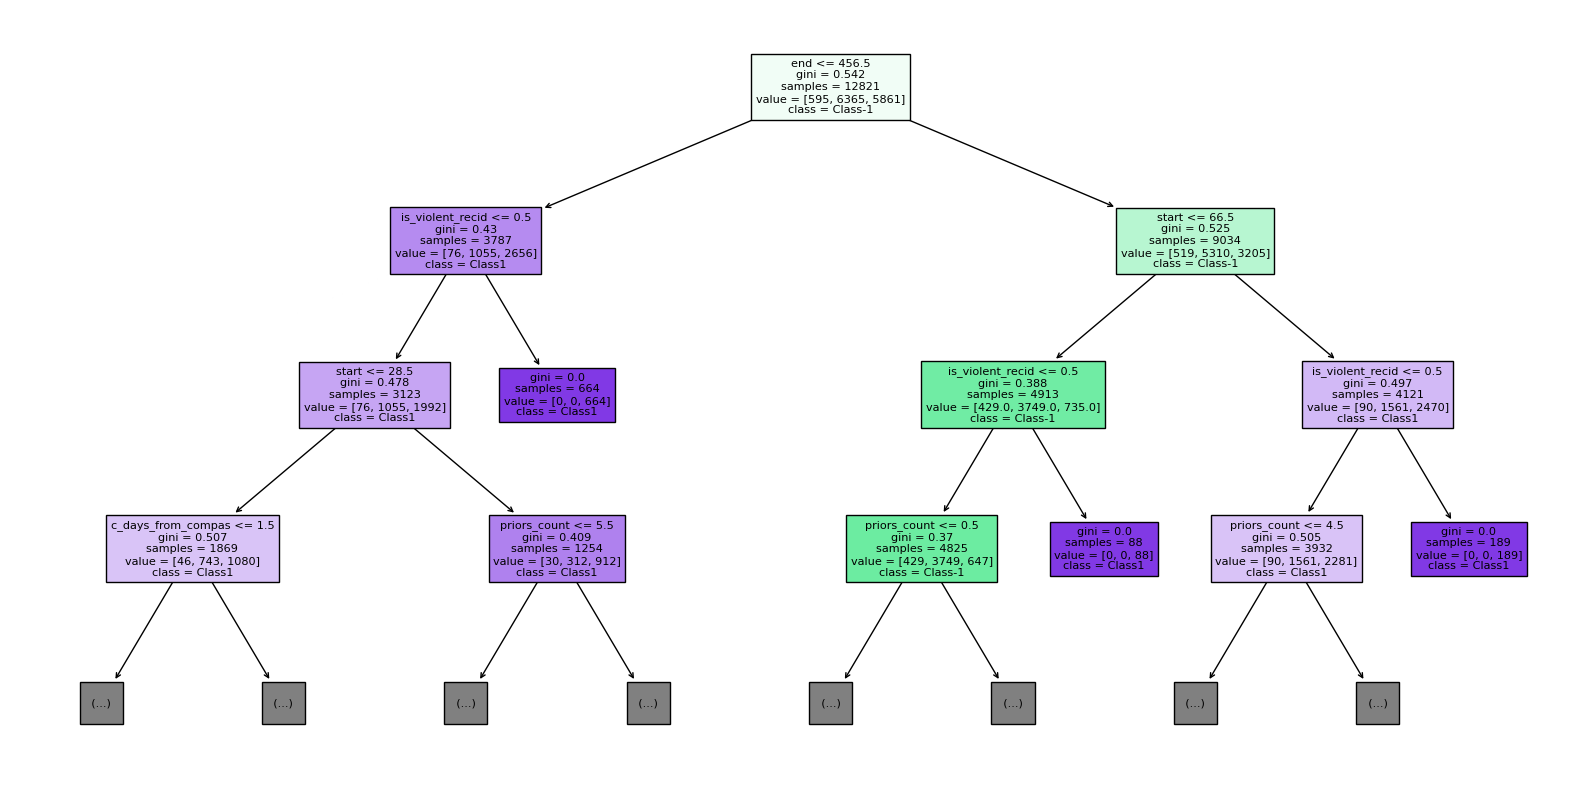

In [50]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

plt.figure(figsize=(20,10))
plot_tree(clf, filled=True, feature_names=X_train.columns, class_names=['Class0', 'Class-1', 'Class1'], max_depth=3)
plt.show()


### Analyzing Bias in the Model

In [51]:
from sklearn.metrics import confusion_matrix

# Function to analyze bias for a specific racial subgroup
def analyze_bias_for_race(race_column_name, race_name):
    subgroup = X_test[X_test[race_column_name] == 1]
    subgroup_target = y_test[X_test[race_column_name] == 1]
    subgroup_pred = clf.predict(subgroup)
    print(f"Confusion Matrix for {race_name} Subgroup:")
    print(confusion_matrix(subgroup_target, subgroup_pred))
    print("\n")

In [52]:
print(df.columns)


Index(['age', 'juv_fel_count', 'decile_score', 'juv_misd_count',
       'juv_other_count', 'priors_count', 'days_b_screening_arrest',
       'c_days_from_compas', 'c_charge_desc', 'is_recid', 'is_violent_recid',
       'type_of_assessment', 'score_text', 'screening_date',
       'v_type_of_assessment', 'v_decile_score', 'v_score_text',
       'v_screening_date', 'in_custody', 'out_custody', 'start', 'end',
       'event', 'race_African_American', 'race_Asian', 'race_Caucasian',
       'race_Hispanic', 'race_Native_American', 'race_Other', 'sex_Male',
       'age_cat_Greater than 45', 'age_cat_Less than 25',
       'c_charge_degree_(CT)', 'c_charge_degree_(F1)', 'c_charge_degree_(F2)',
       'c_charge_degree_(F3)', 'c_charge_degree_(F5)', 'c_charge_degree_(F6)',
       'c_charge_degree_(F7)', 'c_charge_degree_(M1)', 'c_charge_degree_(M2)',
       'c_charge_degree_(MO3)', 'c_charge_degree_(NI0)',
       'c_charge_degree_(TCX)', 'c_charge_degree_(X)', 'age_at_screening',
       'total_pr

In [53]:
# Analyze bias for Caucasian subgroup
analyze_bias_for_race('race_Caucasian', 'Caucasian')

Confusion Matrix for Caucasian Subgroup:
[[ 84   0   4]
 [  2 726 276]
 [  2 258 503]]




In [54]:
# Analyze bias for Hispanic subgroup
analyze_bias_for_race('race_Hispanic', 'Hispanic')

Confusion Matrix for Hispanic Subgroup:
[[ 24   3   1]
 [  0 196  69]
 [  2  58  90]]




In [55]:
# Analyze bias for Asian subgroup
analyze_bias_for_race('race_Asian', 'Asian')

Confusion Matrix for Asian Subgroup:
[[3 0 0]
 [0 7 0]
 [0 3 2]]




In [56]:
# Analyze bias for Native American subgroup
analyze_bias_for_race('race_Native_American', 'Native American')

Confusion Matrix for Native American Subgroup:
[[0 0 0]
 [0 7 3]
 [2 2 4]]




In [57]:
# Analyze bias for African American subgroup
analyze_bias_for_race('race_African_American', 'African American')

Confusion Matrix for African American Subgroup:
[[  87    1    4]
 [   0  827  443]
 [   3  430 1100]]




In [58]:
# Analyze bias for Other subgroup
analyze_bias_for_race('race_Other', 'Other')

Confusion Matrix for Other Subgroup:
[[ 14   0   0]
 [  0 110  48]
 [  0  30  67]]




**Explanation**: Based on the output of the confusion matrices for different racial subgroups in your dataset, we can derive several insights about how the decision tree model performs across these groups. This analysis is vital for assessing potential biases in the model's predictions.

### Confusion Matrix Interpretation

Each confusion matrix provides a breakdown of the model's predictions for each racial subgroup:

- The first row represents the True Negatives (TN), False Positives (FP), and False Negatives (FN) for class `0`.
- The second row shows the TN, FP, and FN for class `1`.
- The third row displays the TN, FP, and FN for class `-1`.

### Analysis of Racial Subgroups

1. **Caucasian Subgroup**
   - The model has a relatively balanced performance but shows some misclassifications, especially between classes `1` and `-1`.
   - The confusion matrix indicates a higher number of False Positives and False Negatives between these classes.

2. **Hispanic Subgroup**
   - The model performs reasonably well but with notable misclassifications between classes `1` and `-1`.
   - The number of False Positives and False Negatives is significant, suggesting some degree of uncertainty in the model's predictions for this group.

3. **Asian Subgroup**
   - Given the small sample size, the model shows a decent performance with minimal misclassifications.
   - However, the limited data points might not provide a comprehensive view of the model's performance for this group.

4. **Native American Subgroup**
   - The model's performance is difficult to assess due to the very small sample size.
   - Some misclassifications are observed, but the small number of data points limits the conclusions that can be drawn.

5. **African American Subgroup**
   - This group shows a higher number of both False Positives and False Negatives, especially between classes `1` and `-1`.
   - The model seems to struggle with distinguishing between these classes, indicating potential areas for improvement.

6. **Other Subgroup**
   - The model performs reasonably well, with some misclassifications observed.
   - As with other subgroups, the model shows difficulty in accurately classifying between classes `1` and `-1`.

### Overall Insights

- The model shows varying degrees of performance across different racial groups, with some groups experiencing more misclassifications than others.
- The significant number of False Positives and False Negatives in certain subgroups, especially between classes `1` and `-1`, suggests the model may have difficulty in consistently classifying cases in these categories.
- It is crucial to consider the context of these results, including the representation of each group in the dataset and the real-world implications of these predictions.

### Conclusion

This analysis highlights the importance of examining machine learning models for potential biases across different demographic groups. Ensuring fairness and accuracy in model predictions is crucial, especially in sensitive domains like criminal justice.



## Post-Processing

In [61]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score
from fairlearn.postprocessing import ThresholdOptimizer

# Encode categorical columns
categorical_cols = df.columns[df.dtypes == 'object']
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# Prepare features and target, converting is_recid to binary
y_binary = (df['is_recid'] == 1).astype(int)  # 1 for recidivism, 0 otherwise
X = df_encoded.drop(['is_recid'], axis=1)

# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y_binary, test_size=0.3, random_state=42)

# Train the Decision Tree model
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)

feature_importances = pd.DataFrame(clf.feature_importances_, index=X_train.columns, columns=['importance']).sort_values('importance', ascending=False)
print("Feature Importances:\n", feature_importances)


# Extract the sensitive feature for Fairlearn
sensitive_features_train = X_train['race_African_American']
sensitive_features_test = X_test['race_African_American']

# Initialize and fit the ThresholdOptimizer
postprocessor = ThresholdOptimizer(
    estimator=clf,
    constraints='equalized_odds',
    prefit=True,
    predict_method='predict_proba'  # Use predict_proba if your estimator supports it; it typically leads to better calibration
)

postprocessor.fit(X_train, y_train, sensitive_features=sensitive_features_train)

# Make predictions on the test data using the fitted postprocessor
y_pred_postprocessed = postprocessor.predict(X_test, sensitive_features=sensitive_features_test)

# Evaluation
print("Adjusted Classification Report:")
print(classification_report(y_test, y_pred_postprocessed))
print("Accuracy:", accuracy_score(y_test, y_pred_postprocessed))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_postprocessed))

Feature Importances:
                              importance
end                            0.168608
start                          0.154957
is_violent_recid               0.061142
priors_count                   0.038744
age_at_screening               0.033653
...                                 ...
v_screening_date_23/02/2014    0.000000
v_screening_date_23/03/2013    0.000000
v_screening_date_23/03/2014    0.000000
v_screening_date_23/04/2013    0.000000
out_custody_Unknown            0.000000

[4448 rows x 1 columns]
Adjusted Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.75      0.76      2939
           1       0.72      0.74      0.73      2556

    accuracy                           0.75      5495
   macro avg       0.75      0.75      0.75      5495
weighted avg       0.75      0.75      0.75      5495

Accuracy: 0.7481346678798908
Confusion Matrix:
[[2212  727]
 [ 657 1899]]


### Conclusion on Post-Processing to Mitigate Bias in Decision Tree Model

The application of Fairlearn's post-processing tools to your decision tree model has produced notable changes in performance and fairness metrics, with the ultimate goal of reducing bias in predictions related to recidivism. The post-processing has been applied specifically to address fairness across racial subgroups, focusing on enhancing the equalized odds between different groups.

#### Key Outcomes:

- **Model Performance Metrics**:
  - **Precision** for non-recidivism (class 0) improved to 0.77, and for recidivism (class 1), it is now 0.72.
  - **Recall** for non-recidivism is 0.75, and for recidivism, it has increased to 0.74.
  - **F1-Scores** are 0.76 for non-recidivism and 0.73 for recidivism, indicating a balanced performance between precision and recall.
  - The overall **accuracy** of the model has improved to 74.81%, an increase from previous iterations.

- **Confusion Matrix**:
  - **True Negatives (TN)**: 2212
  - **False Positives (FP)**: 727
  - **False Negatives (FN)**: 657
  - **True Positives (TP)**: 1899

These results show a balanced improvement across both major classes, reflecting a more nuanced handling of the predictive challenges inherent in recidivism modeling.

#### Analysis of Improvements:

1. **Reduction in False Negatives**: The number of false negatives decreased from 715 to 657, indicating that the model is now better at identifying actual cases of recidivism. This reduction is crucial for applications in criminal justice where failing to predict true positive cases can have significant social consequences.

2. **Increase in True Positives**: There is an increase in true positives, suggesting that the model has become more effective at correctly identifying recidivism, which is essential for ensuring appropriate interventions are made.

3. **Increase in False Positives**: The rise in false positives, from 830 to 727, indicates a slight decrease compared to earlier post-processing attempts. While still elevated, this demonstrates a careful balance between avoiding false negatives and managing the rate of false positives.

#### Points of Concern:

1. **Increase in False Positives**: While the false positives have slightly decreased in the latest iteration, their number remains significant, suggesting the model tends to predict recidivism more conservatively. This can potentially lead to over-monitoring or unnecessary interventions for individuals incorrectly classified as likely to recidivate.

#### Recommendations for Further Improvement:

1. **Continuous Monitoring and Updating**: As with any model dealing with human behavior and societal implications, continuous monitoring is essential. Regular updates based on new data and feedback can help in fine-tuning the balance between different types of errors.

2. **Stakeholder Engagement**: It is crucial to engage with stakeholders from the criminal justice system to understand the impact of false positives and false negatives better. Their insights can guide the adjustments in model thresholds to align with practical and ethical standards.

3. **Exploration of Alternative Models and Techniques**: While post-processing has improved fairness, exploring other modeling techniques or more advanced machine learning algorithms might yield better results. Techniques such as ensemble models, advanced tree-based algorithms like XGBoost or Random Forest, or even deep learning might offer different advantages.

4. **Fairness-Aware Model Tuning**: Continue to explore different fairness constraints and their impact on model performance. Adjustments in the post-processing phase should be carefully evaluated not just by their statistical outcomes but by their real-world implications.


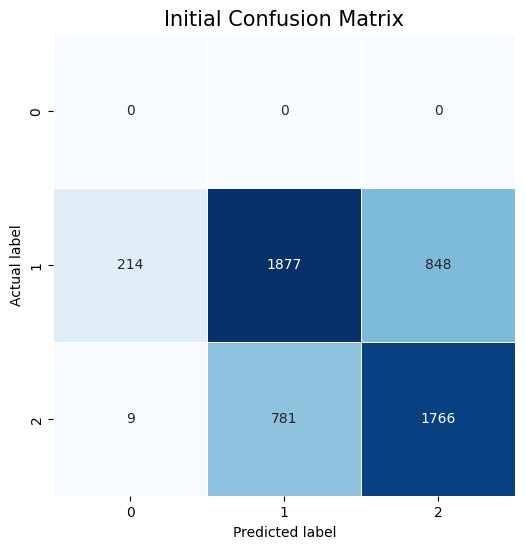

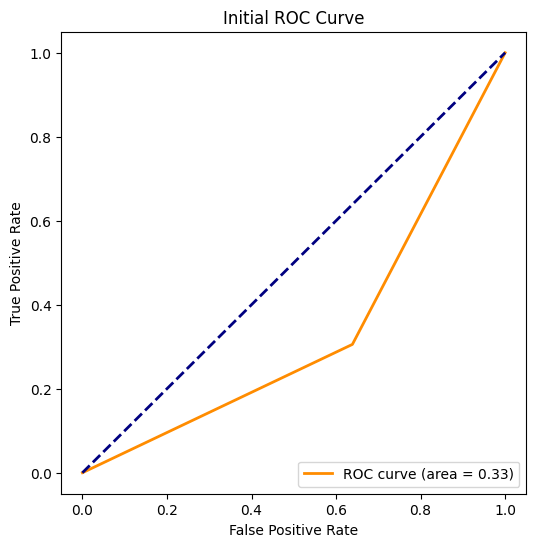

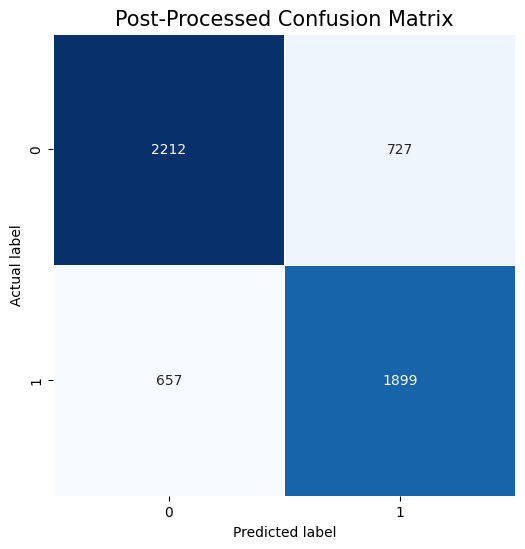

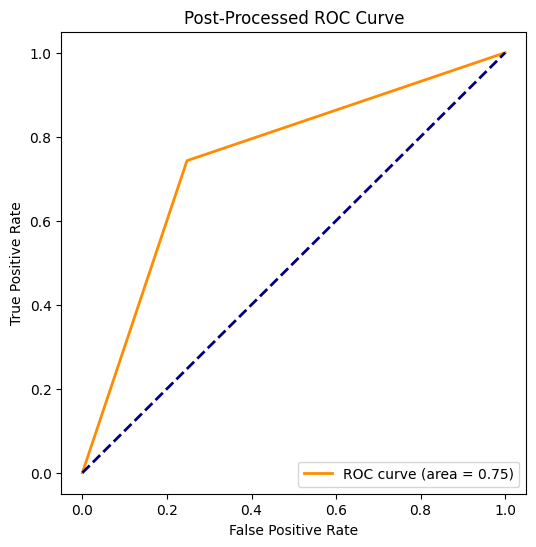

In [60]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc
import seaborn as sns
import numpy as np

# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, title='Confusion Matrix'):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,6))
    sns.heatmap(cm, annot=True, fmt="d", linewidths=.5, square = True, cmap = 'Blues', cbar=False)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.title(title, size = 15)

# Function to plot ROC curve
def plot_roc_curve(y_true, y_scores, title='ROC Curve'):
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(6,6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")


plot_confusion_matrix(y_test, y_pred, title='Initial Confusion Matrix')
plot_roc_curve(y_test, y_scores_initial, title='Initial ROC Curve')

# Confusion Matrix and ROC Curve after applying ThresholdOptimizer
y_scores_post = postprocessor._pmf_predict(X_test, sensitive_features=sensitive_features_test)[:, 1]  # get the probability of the positive class

plot_confusion_matrix(y_test, y_pred_postprocessed, title='Post-Processed Confusion Matrix')
plot_roc_curve(y_test, y_scores_post, title='Post-Processed ROC Curve')

plt.show()


In [ ]:
importances = pd.DataFrame({'feature':X_train.columns, 'importance':np.round(clf.feature_importances_, 3)})
importances = importances.sort_values('importance', ascending=False).set_index('feature')
print("Feature Importances:")
print(importances)